In [1]:
import sys
print(sys.executable)


C:\Users\Util1445\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [3]:
import pandas as pd

# Make sure the path is correct
data = pd.read_excel(r"C:\Users\Util1445\Downloads\DFF.xlsx",
                     sheet_name=0,
                     parse_dates=['DATE'],
                     index_col='DATE')

# Optional: clean column names
data.rename(columns=lambda x: x.strip(), inplace=True)

# Preview the data
data.head()

,DFF
DATE,
2020-11-14,0.09
2020-11-15,0.09
2020-11-16,0.09
2020-11-17,0.09
2020-11-18,0.09


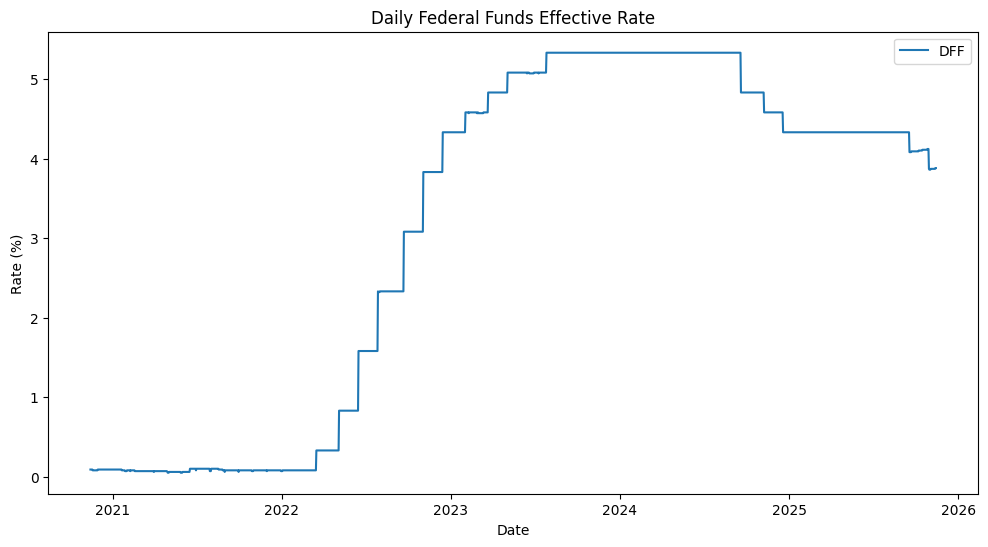

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['DFF'], label='DFF')
plt.title('Daily Federal Funds Effective Rate')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, signif=0.05, name='Series'):
    """
    Perform Augmented Dickey-Fuller test to check stationarity.

    Parameters:
    -----------
    series : pandas Series
        Time series data to test
    signif : float
        Significance level (default 0.05)
    name : str
        Name of the series for printing

    Returns:
    --------
    bool : True if series is likely stationary, False otherwise
    """
    print(f'\nADF Test for "{name}":')
    series_clean = series.dropna()  # remove missing values
    result = adfuller(series_clean, autolag='AIC')
    
    print(f'ADF Statistic : {result[0]:.4f}')
    print(f'p-value       : {result[1]:.4f}')
    print(f'#Lags Used    : {result[2]}')
    print(f'Number of Obs : {result[3]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < signif:
        print(f"Conclusion    : {name} is likely STATIONARY ✅")
        return True
    else:
        print(f"Conclusion    : {name} is likely NON-STATIONARY ❌")
        return False

# Run ADF test on your DFF series
is_stationary = adf_test(data['DFF'], name='Federal Funds Rate (DFF)')



ADF Test for "Federal Funds Rate (DFF)":
ADF Statistic : -1.4971
p-value       : 0.5350
#Lags Used    : 0
Number of Obs : 1826
Critical Values:
   1%: -3.4339
   5%: -2.8631
   10%: -2.5676
Conclusion    : Federal Funds Rate (DFF) is likely NON-STATIONARY ❌



ADF Test on First-Differenced Series:

ADF Test for "First-Differenced Federal Funds Rate (DFF)":
ADF Statistic : -42.8727
p-value       : 0.0000
#Lags Used    : 0
Number of Obs : 1825
Critical Values:
   1%: -3.4339
   5%: -2.8631
   10%: -2.5676
Conclusion    : First-Differenced Federal Funds Rate (DFF) is likely STATIONARY ✅


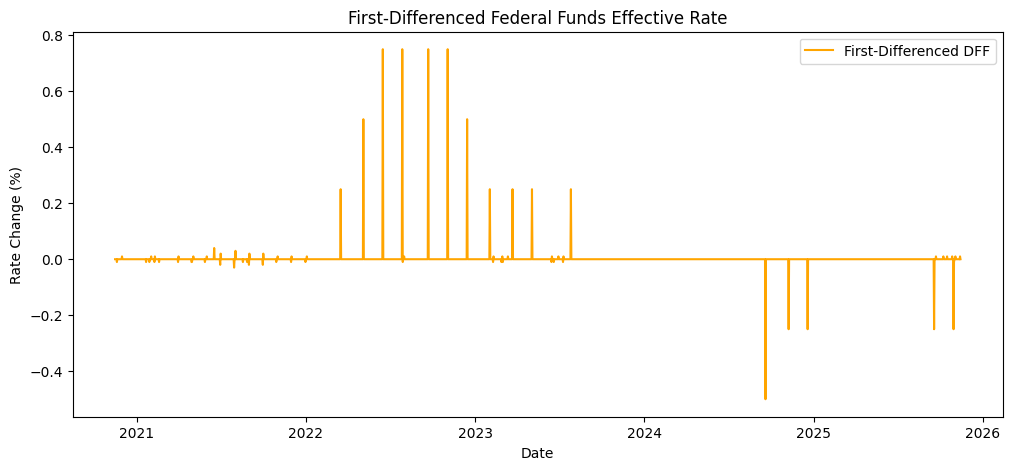

In [8]:
# Apply First Differencing if raw series is non-stationary
if not is_stationary:
    # First difference of the DFF series
    data_diff = data['DFF'].diff().dropna()
    
    # Run ADF test on the differenced series
    print("\nADF Test on First-Differenced Series:")
    is_stationary_diff = adf_test(data_diff, name='First-Differenced Federal Funds Rate (DFF)')
    
    # Optional: plot the differenced series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.plot(data_diff, label='First-Differenced DFF', color='orange')
    plt.title('First-Differenced Federal Funds Effective Rate')
    plt.xlabel('Date')
    plt.ylabel('Rate Change (%)')
    plt.legend()
    plt.show()

In [9]:
# Determine Integrated Orders for ARIMA/SARIMA
if not is_stationary:
    # Non-stationary → first differencing needed
    d = 1       # non-seasonal differencing order
    D = 0       # seasonal differencing not needed (daily data)
    data_diff = data['DFF'].diff().dropna()
else:
    # Already stationary → no differencing required
    d = 0
    D = 0
    data_diff = data['DFF']  # use original series

# Display integrated orders
print("\nIntegrated Orders for ARIMA/SARIMA:")
print(f"  Non-Seasonal differencing (d) = {d}")
print(f"  Seasonal differencing (D)     = {D} (not needed for daily FED Funds data)")



Integrated Orders for ARIMA/SARIMA:
  Non-Seasonal differencing (d) = 1
  Seasonal differencing (D)     = 0 (not needed for daily FED Funds data)


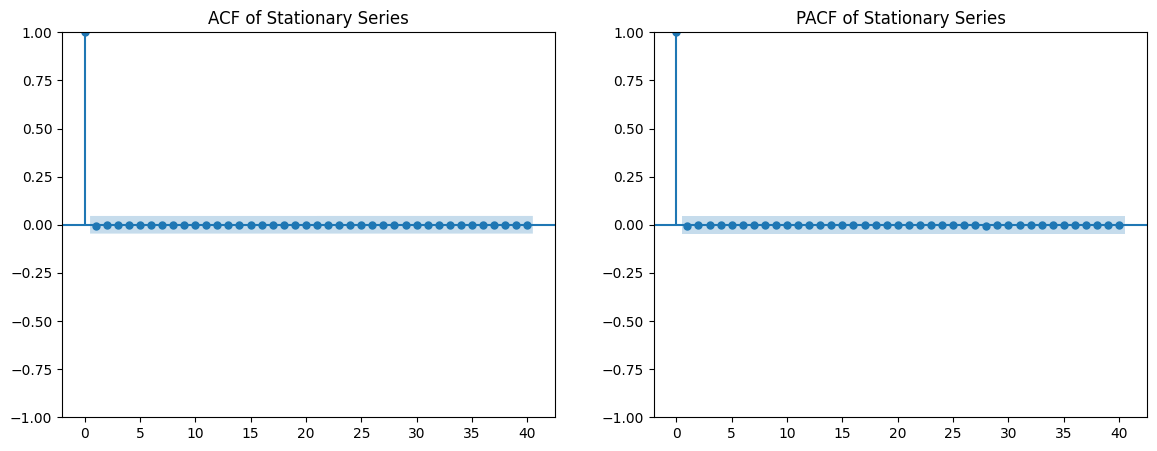

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the stationary series (data_diff)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plot_acf(data_diff, lags=40, ax=plt.gca())
plt.title('ACF of Stationary Series')

plt.subplot(1,2,2)
plot_pacf(data_diff, lags=40, ax=plt.gca(), method='ywm')
plt.title('PACF of Stationary Series')

plt.show()

In [11]:
import pandas as pd
import statsmodels.api as sm

# Ensure daily frequency
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Fit ARIMA models with more iterations
model1 = sm.tsa.ARIMA(data['DFF'], order=(1,d,0)).fit(method_kwargs={"maxiter":500})
model2 = sm.tsa.ARIMA(data['DFF'], order=(0,d,1)).fit(method_kwargs={"maxiter":500})
model3 = sm.tsa.ARIMA(data['DFF'], order=(1,d,1)).fit(method_kwargs={"maxiter":500})

# Print AIC/BIC for comparison
print(f"ARIMA(1,{d},0) → AIC: {model1.aic}, BIC: {model1.bic}")
print(f"ARIMA(0,{d},1) → AIC: {model2.aic}, BIC: {model2.bic}")
print(f"ARIMA(1,{d},1) → AIC: {model3.aic}, BIC: {model3.bic}")

C:\Users\Util1445\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1,1,0) → AIC: -6202.00425820477, BIC: -6190.98449208246
ARIMA(0,1,1) → AIC: -6202.0042900142635, BIC: -6190.984523891953
ARIMA(1,1,1) → AIC: -6200.004295722787, BIC: -6183.474646539322



Best ARIMA model found: ARIMA(0, 1, 0) with AIC = -6199.599232540639



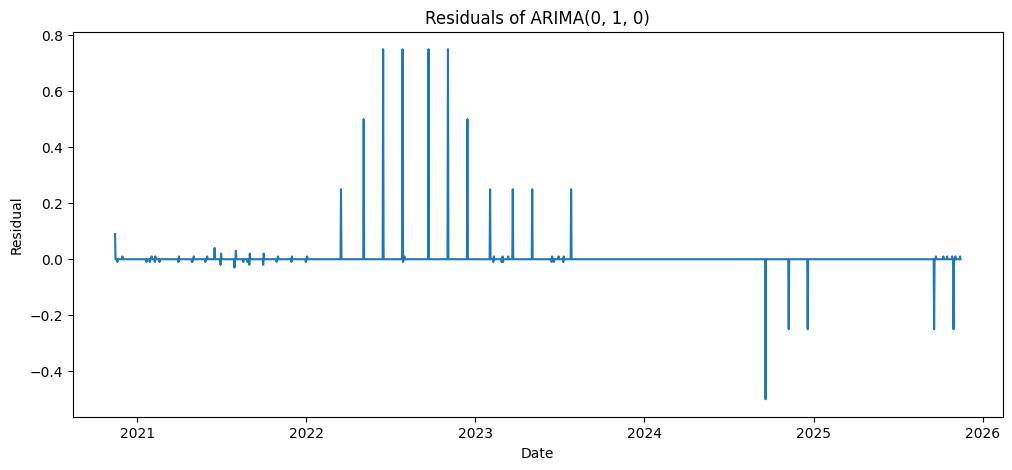

<Figure size 1200x500 with 0 Axes>

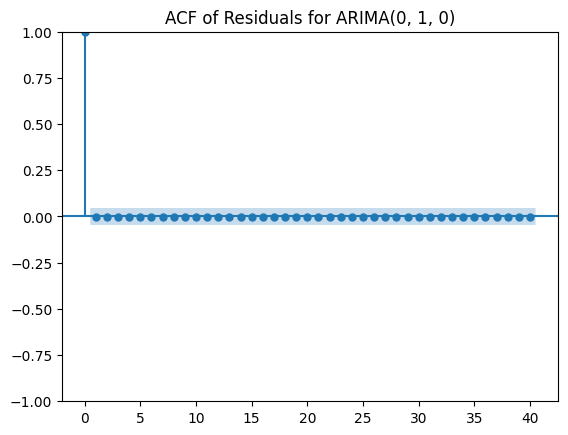

Residuals Mean: 0.0021237000547345373
Residuals Std Dev: 0.04423228566526886


In [13]:
import warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import itertools
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# 1️⃣ Ensure datetime index and daily frequency
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Step 1: Differencing order (from ADF result)
d = 1  # make sure this matches your previous analysis

# 2️⃣ Grid search for best ARIMA(p,d,q)
p = range(0,3)
q = range(0,3)

best_aic = float('inf')
best_order = None
best_model = None

for i, j in itertools.product(p, q):
    try:
        model = sm.tsa.SARIMAX(
            data['DFF'],
            order=(i, d, j),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(maxiter=2000, disp=False)  # pass maxiter and disp here
        
        if model.aic < best_aic:  # <-- fixed indentation
            best_aic = model.aic
            best_order = (i, d, j)
            best_model = model

    except Exception as e:
        # Uncomment to see which models fail:
        # print(f"Model ({i},{d},{j}) failed: {e}")
        continue

print(f"\nBest ARIMA model found: ARIMA{best_order} with AIC = {best_aic}\n")

# 3️⃣ Diagnostic Checking of Residuals
residuals = best_model.resid

# Plot residuals
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title(f'Residuals of ARIMA{best_order}')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Plot ACF of residuals
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=40)
plt.title(f'ACF of Residuals for ARIMA{best_order}')
plt.show()

# Optional: Residual stats
print("Residuals Mean:", residuals.mean())
print("Residuals Std Dev:", residuals.std())


                               SARIMAX Results                                
Dep. Variable:                    DFF   No. Observations:                 1827
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3105.011
Date:                Sun, 23 Nov 2025   AIC                          -6206.023
Time:                        09:57:20   BIC                          -6195.003
Sample:                    11-14-2020   HQIC                         -6201.958
                         - 11-14-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0021      0.002      1.228      0.220      -0.001       0.005
sigma2         0.0020   1.03e-05    190.123      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.03   Jarque-

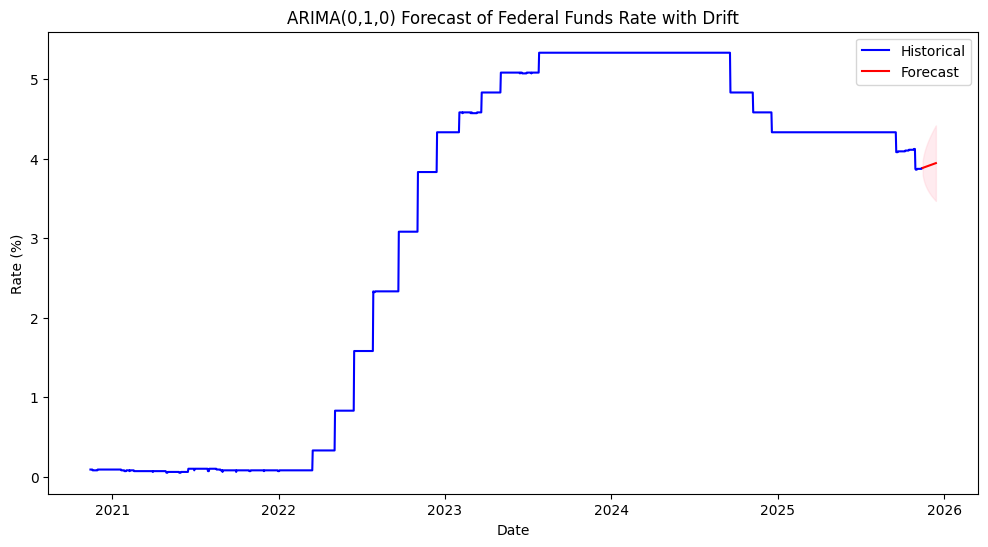

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(0,1,0) with drift (linear trend)
best_model = ARIMA(data['DFF'], order=(0,1,0), trend='t').fit()
print(best_model.summary())

# Forecast 30 days ahead
forecast_steps = 30
forecast_obj = best_model.get_forecast(steps=forecast_steps)
forecast_values = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Plot forecast with confidence intervals
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['DFF'], label='Historical', color='blue')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('ARIMA(0,1,0) Forecast of Federal Funds Rate with Drift')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.show()


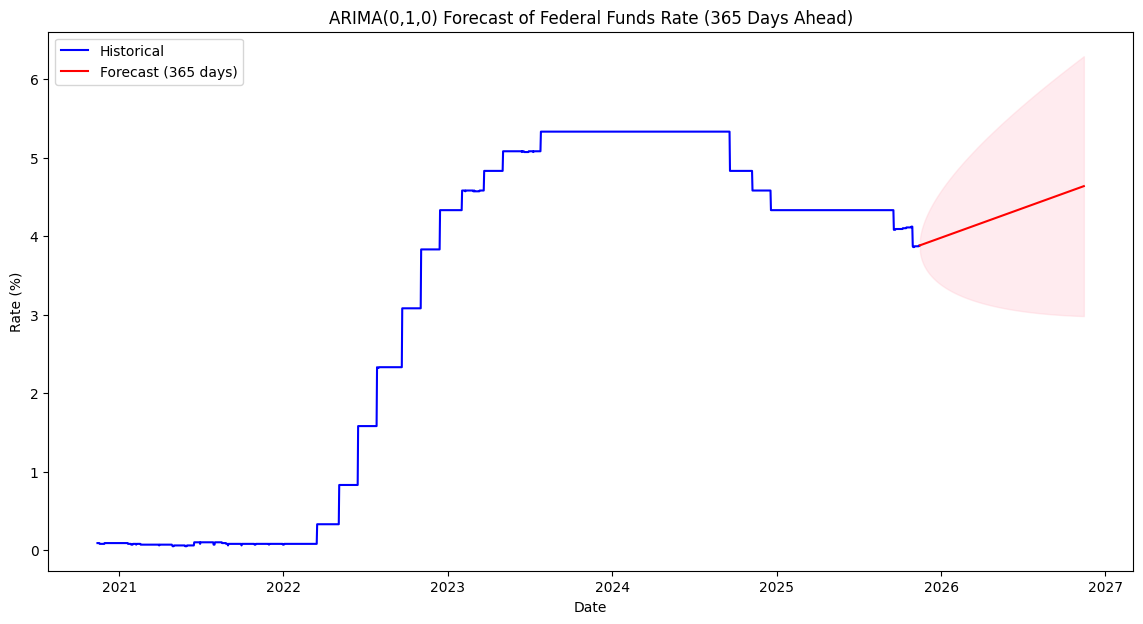

In [15]:
# Forecast 365 days ahead using ARIMA(0,1,0) with drift
forecast_steps = 365

forecast_obj = best_model.get_forecast(steps=forecast_steps)
forecast_values = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Plot
plt.figure(figsize=(14,7))
plt.plot(data['DFF'], label='Historical', color='blue')
plt.plot(forecast_values, label='Forecast (365 days)', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('ARIMA(0,1,0) Forecast of Federal Funds Rate (365 Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.show()
